In [1]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, NoNorm, PowerNorm
import pickle
import numpy as np
import math
import pandas as pd
from scipy.spatial import KDTree
from itertools import combinations
from pyproj import Transformer
from shapely import LineString, MultiLineString
from shapely.geometry import Point, box
import multiprocessing
from functools import partial
import time

In [2]:
SUBWAY_SPEED = 3 # used in euclidean dist
TARGET_CRS = "EPSG:3095"

def jittered_weight(u, v, data):
    jitterSize = 0.03
    base_length = data['length']
    jitter = random.gauss(1, jitterSize)
    return base_length * jitter
def jitter_sqrt(u, v, data):
    strength = 0.5 # strength of 1 means 10 m path will be jittered by 1 * sqrt(10) = 3
                # or 100 m path will get jittered by 1 * sqrt (100) = 10
    base_length = data['length']
    if base_length <= 0:
        return 0.001
    sigma = strength * math.sqrt(base_length)
    noise = random.gauss(0, sigma)
    return max(0.001, base_length + noise)
def euclidean_dist(u, v):
    return np.linalg.norm(np.array(u) - np.array(v)) / SUBWAY_SPEED 

def pathfind(source_target_pair, graph, weight_func, heuristic_func, exponent_val):
    source_node, target_node = source_target_pair
    source_node = tuple(source_node)
    target_node = tuple(target_node)
    try: 
        path = nx.astar_path(graph, source_node, target_node, 
                            weight=weight_func, heuristic=heuristic_func)
        network_dist = sum(graph.edges[u, v]['length'] for u, v in zip(path[:-1], path[1:]))
        distance = np.linalg.norm(np.array(source_node) - np.array(target_node))
        directness = distance / (network_dist + 0.001)
        influence = directness ** exponent_val
        path_edges = list(zip(path[:-1], path[1:]))
        # Return all the edges from this path and the influence score for this path
        return (path_edges, influence)
    except nx.NetworkXNoPath:
        return None

def offset_geometries(gdf, offset_distance):
    new_geometries = []
    # Center the offsets around zero
    start_offset = -offset_distance * (len(gdf) - 1) / 2
    for i, row in enumerate(gdf.itertuples()):
        # Calculate the offset for this specific line
        current_offset = start_offset + i * offset_distance
        new_geom = row.geometry.parallel_offset(current_offset, 'left', join_style=2)
        new_geometries.append(new_geom)
    return new_geometries


In [10]:
num_iterations = 1000000


print("Downloading and building graph from OpenStreetMap...")
place_name = "Tokyo, Japan"
bbox = (139.546967,35.524403,139.943848,35.842308)
center_lon, center_lat = (bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2
transformer = Transformer.from_crs("EPSG:4326", TARGET_CRS, always_xy = True)
center_x, center_y = transformer.transform(center_lon, center_lat)
center_point = np.array([center_x, center_y])

# --- 1. Get data by uncommenting below 4 lines! ---

# G_directed = ox.graph_from_bbox(bbox = bbox, network_type='drive')
# G_proj = ox.project_graph(G_directed, to_crs=TARGET_CRS)
# with open('graph_tokyo.pkl', 'wb') as f:
#     pickle.dump(G_proj, f)

with open('graph_tokyo.pkl', 'rb') as f:
    G_proj = pickle.load(f)
G_initial = nx.Graph(G_proj)
print(f"Downloaded graph with {nx.number_connected_components(G_initial)} components.")
df_streets = ox.graph_to_gdfs(G_proj, nodes=False)

Downloaded graph with 1 components.


In [59]:
# --- 2. Convert Graph Nodes to Coordinate Tuples ---
print("Converting graph nodes from OSM IDs to coordinates...")
pos = {node: (data['x'], data['y']) for node, data in G_initial.nodes(data=True)}
G = nx.Graph() # This will be our final graph with coordinate nodes
for u, v, data in G_initial.edges(data=True):
    u_coords = pos[u]
    v_coords = pos[v]
    G.add_edge(u_coords, v_coords, **data)
street_nodes = list(G.nodes())

# # --- 2.5. subway! ---
print('loading subway data...')

station_tags = {'railway': 'station', 'station': 'subway'}
stations_gdf = ox.features_from_bbox(bbox, station_tags)
stations_gdf = stations_gdf.to_crs(TARGET_CRS)
# Filter for valid Point geometries
stations_gdf = stations_gdf[stations_gdf.geometry.type == 'Point']
print(f"Downloaded {len(stations_gdf)} subway stations.")

line_tags = {'railway': 'subway'}
lines_gdf = ox.features_from_bbox(bbox, line_tags)
lines_gdf = lines_gdf.to_crs(TARGET_CRS)
lines_gdf['route'] = lines_gdf['name:en']
print(f"Downloaded {len(lines_gdf)} subway line segments.")


# prepare street graph G
for u, v, data in G.edges(data=True):
    G.edges[u, v]['type'] = 'street'

subG = nx.Graph()

all_subway_data = [] # We'll create a list of dictionaries
for index, row in lines_gdf.iterrows():
    line = row.geometry
    route = row['route'] 
    segments = [LineString(pair) for pair in zip(line.coords, line.coords[1:])]
    for seg in segments:
        all_subway_data.append({'geometry': seg, 'route': route})
segmented_gdf = gpd.GeoDataFrame(all_subway_data, crs=TARGET_CRS)

# --- Part 2: Build the graph from our new, detailed list ---
for seg_data in all_subway_data:
    segment = seg_data['geometry']
    route = seg_data['route'] 
    start_node = segment.coords[0][:2]
    end_node = segment.coords[-1][:2]
    if start_node != end_node:
        travel_time = segment.length / (SUBWAY_SPEED) #* subway_speeds[route])
        subG.add_edge(start_node, end_node,
                    length=travel_time, 
                    type='subway',
                    route=route) 

# 3. find and bridge gaps between segment!
endpoints = []
for index, row in lines_gdf.iterrows():
    line = row.geometry
    if len(line.coords) > 1: # Ensure the line is valid
        endpoints.append(line.coords[0])
        endpoints.append(line.coords[-1])
unique_endpoints = list(set(endpoints))
endpoint_tree = KDTree(unique_endpoints)

# Find all pairs of endpoints that are within 20 meters of each other
gap_pairs = endpoint_tree.query_pairs(r=20)
for (i, j) in gap_pairs:
    node1 = unique_endpoints[i]
    node2 = unique_endpoints[j]
    dist = euclidean_dist(node1, node2)
    subG.add_edge(node1, node2, length = dist / SUBWAY_SPEED, type='subway')

G = nx.compose(G, subG)

# connecting stations!
ENTER_STATION = 30 # meters from station to street (walking is ~ 1 m/s)
TRAIN_WAIT = 400 # meters from station to getting on train (applied both ways)

print("Connecting networks at station entrances...")
station_id_to_node = {}
for station in stations_gdf.itertuples():
    platform_coords = (station.geometry.x, station.geometry.y)
    G.add_node(platform_coords)
    station_id_to_node[station.index] = platform_coords

subway_nodes = [n for n, d in G.nodes(data=True) if G.degree(n) > 0 and all(G.edges[n, neighbor].get('type') == 'subway' for neighbor in G.neighbors(n))]
subway_tree = KDTree(subway_nodes)

street_tree = KDTree(street_nodes) # connect station to street
for station_id, platform_node in station_id_to_node.items():
    dist, idx = street_tree.query(platform_node)
    nearest_street_node = street_nodes[idx]
    entrance_time = dist + ENTER_STATION
    G.add_edge(platform_node, nearest_street_node, length = dist + ENTER_STATION, type='station_entrance')

# for station in stations_gdf.itertuples():
#     for route in station.routes:
#         try:
#             # 1. Find ALL possible line segments for the current route
#             platform_coords = (station.geometry.x, station.geometry.y)
#             platform_point = Point(platform_coords)

#             possible_lines = lines_gdf[lines_gdf['route'] == route]
#             if possible_lines.empty:
#                 print('route not found ' + route)
#             route_geom = possible_lines.geometry.union_all()
#             track_point = route_geom.interpolate(route_geom.project(platform_point))
#             fallback = False
#             if track_point:
#                 track_node_coords = (track_point.x, track_point.y)
#                 dist, idx = subway_tree.query(track_node_coords)
#                 nearest_track_node_on_route = subway_nodes[idx]
#                 platform_track_dist = euclidean_dist(platform_coords, nearest_track_node_on_route)
#             else: 
#                 fallback = True 
#             if fallback or platform_track_dist > 200 and route != '5':
#                 print(f"warning: Large platform-to-track distance of {platform_track_dist:.0f}m "
#                     f"for route {route} at {station.stop_name}")
#                 # fallback if interpolate doesn't work: find closest node
#                 route_nodes = []
#                 if isinstance(route_geom, MultiLineString):
#                     for line in route_geom.geoms:
#                         route_nodes.extend(line.coords)
#                 else:
#                     route_nodes.extend(route_geom.coords)
#                 route_tree = KDTree(route_nodes)
#                 dist, idx = route_tree.query(platform_coords)
#                 nearest_track_node_on_route = route_nodes[idx]
#             # Add an edge from the platform to the specific track
#             G.add_edge(platform_coords, nearest_track_node_on_route, 
#                     length=TRAIN_WAIT + platform_track_dist*1.5, type='platform_access')
#             #print('added edge ' + route + station.stop_name)
#         except (IndexError, KeyError): # if route doesn't have a geometry
#             print("route doesn't have geometry " + route)
#             pass

# adding stop time penalties
STOP_TIME = 20 # applied twice while passing a station
track_nodes_with_stops = set()
for station_id, platform_node in station_id_to_node.items():
    for neighbor in G.neighbors(platform_node):
        if G.edges[platform_node, neighbor].get('type') == 'platform_access':
            track_nodes_with_stops.add(neighbor)
for track_node in track_nodes_with_stops:
    for neighbor in G.neighbors(track_node):
        edge_data = G.edges[track_node, neighbor]
        if edge_data.get('type') == 'subway':
            edge_data['length'] += STOP_TIME
    
print("Multi-modal graph creation complete!")

Converting graph nodes from OSM IDs to coordinates...
loading subway data...
Downloaded 794 subway stations.
Downloaded 1703 subway line segments.
Connecting networks at station entrances...
Multi-modal graph creation complete!


In [5]:
# --- 2.6 load population! --
print('loading population...')
kontur_filepath = "../data/nystreets/kontur_population_JP_20231101.gpkg"
west, south, east, north = bbox 
bbox_gdf_latlon = gpd.GeoDataFrame(
    geometry=[box(west, south, east, north)],
    crs="EPSG:3857")
bbox_gdf_projected = bbox_gdf_latlon.to_crs(TARGET_CRS)
projected_bbox_coords = tuple(bbox_gdf_projected.total_bounds)
pop_gdf = gpd.read_file(
    kontur_filepath,
    #bbox=projected_bbox_coords,
)

loading population...


C:\Users\anita\anaconda3\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [6]:
pop_gdf = pop_gdf.to_crs(TARGET_CRS)
pop_centers_gdf = pop_gdf.copy() # collapse to centers
pop_centers_gdf['geometry'] = pop_centers_gdf.geometry.centroid
pop_points = np.array([p.coords[0] for p in pop_centers_gdf.geometry])
pop_values = pop_centers_gdf['population'].values
pop_tree = KDTree(pop_points)
print(f"Data loaded successfully. Found {len(pop_gdf)} population grid cells.")

Data loaded successfully. Found 229211 population grid cells.


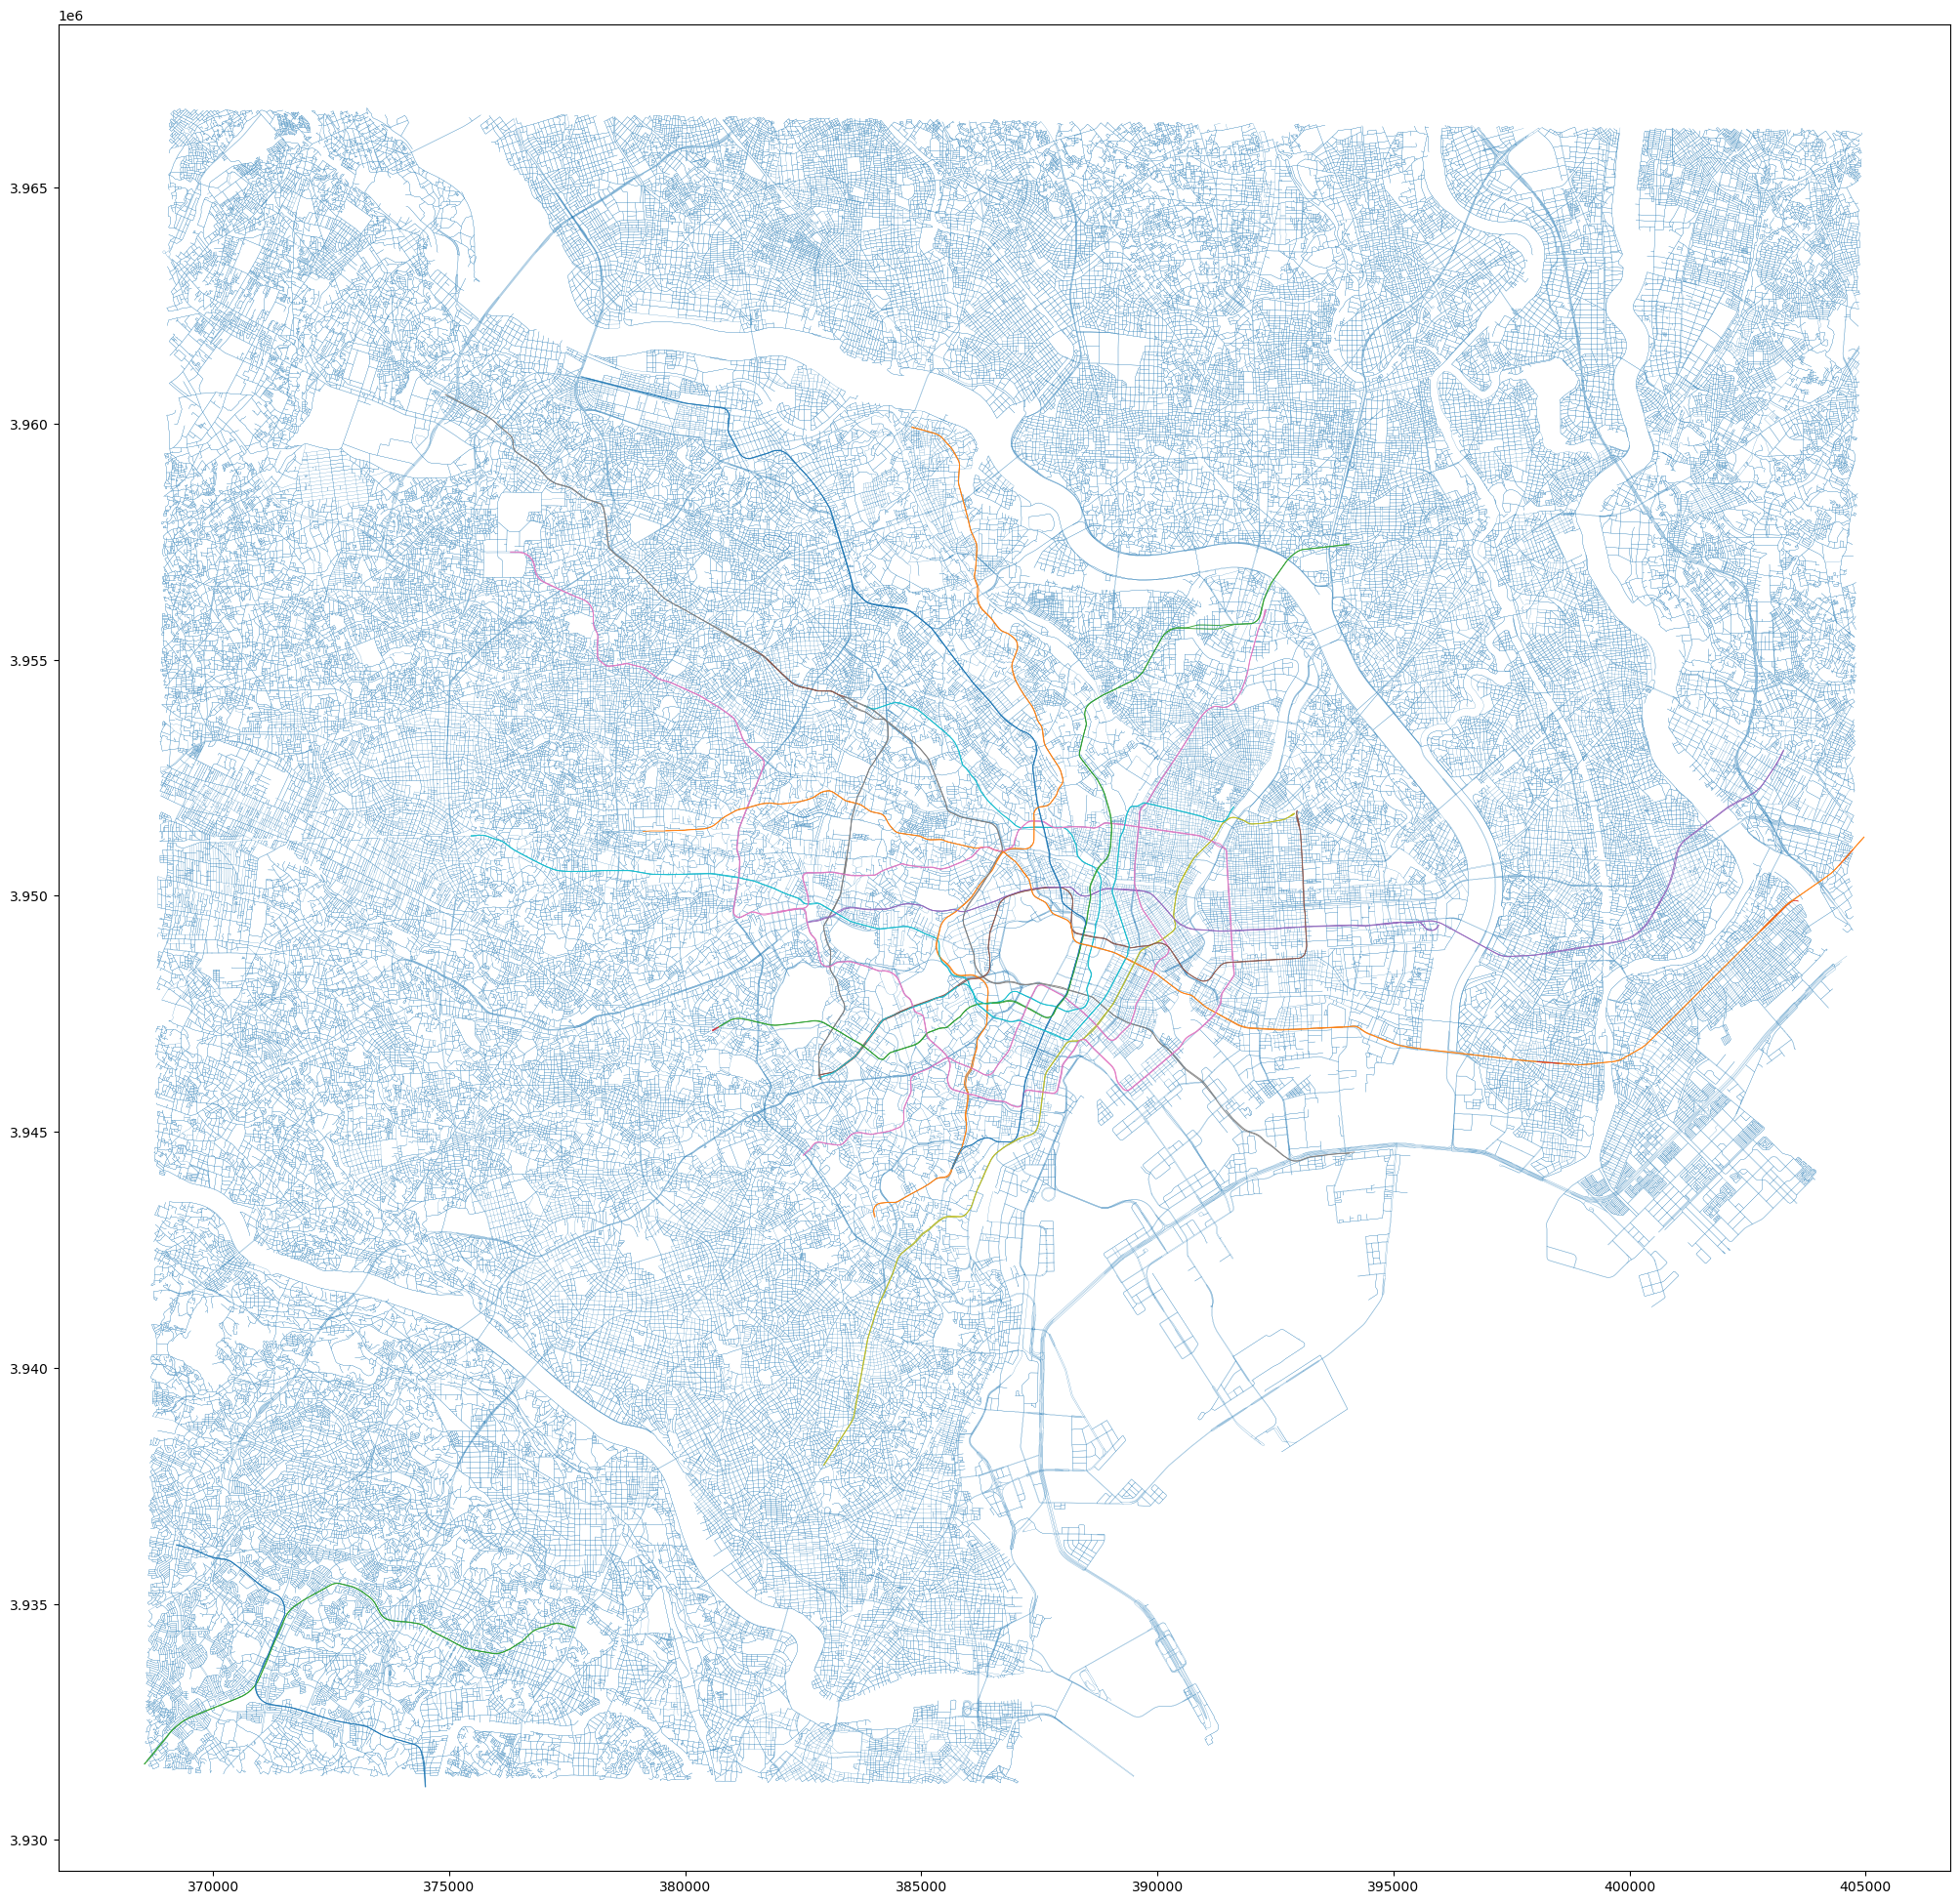

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
df_streets.plot(ax=ax, linewidth=0.15)
lines_gdf.plot(ax=ax, column='colour', linewidth=0.6)
plt.savefig('tokyo.png')
plt.show()

In [61]:
lines_gdf = lines_gdf.dropna(axis=1, thresh=int(len(lines_gdf) * 0.05))
#lines_gdf = lines_gdf[['geometry', 'colour', 'name', 'name:en', 'operator', 'railway', 'layer', 'frequency', 'maxspeed', 'service']]

In [72]:
random_color

array([[0.55562838, 0.85702088, 0.80760725, 0.8302054 , 0.5598916 ,
        0.84757463, 0.28754077, 0.21406276, 0.26465016, 0.70127207,
        0.10920197, 0.57513668, 0.12925922, 0.06508218, 0.25768429,
        0.70984865, 0.61879973, 0.78261994, 0.10906391, 0.69962415,
        0.81952811, 0.86545903, 0.44436918, 0.7938292 , 0.03389118,
        0.48094133, 0.57874521, 0.95401766, 0.36638059, 0.66257803,
        0.21974218, 0.29730162, 0.21401326, 0.89098947, 0.53113209,
        0.69456337, 0.90564179, 0.40821545, 0.01071255, 0.96481382,
        0.38701935, 0.35337064, 0.93628135, 0.5949171 , 0.70799977,
        0.63243403, 0.90673978, 0.76557583, 0.08959869, 0.74813473,
        0.68573381, 0.96820502, 0.20723414, 0.71584769, 0.08158422,
        0.27819864, 0.3200377 , 0.0356241 , 0.44110091, 0.21138904,
        0.56480075, 0.02228994, 0.87645229, 0.30022099, 0.7474698 ,
        0.93418072, 0.82125516, 0.17611274, 0.2388428 , 0.54583299,
        0.09293988, 0.20075728, 0.79464534, 0.98

<Figure size 1000x1000 with 0 Axes>

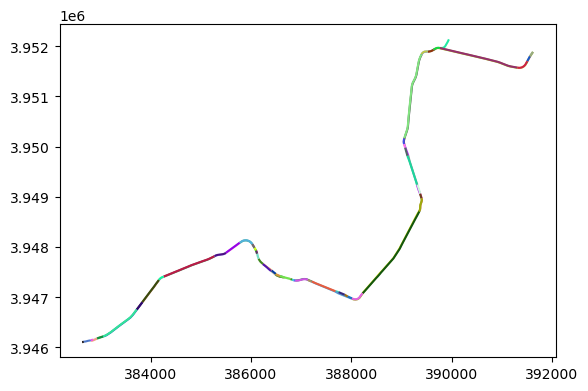

In [75]:
fig, ax = plt.plo(1, 1, figsize=(25, 25))
ginza = lines_gdf[lines_gdf['name:en'] == 'Tokyo Metro Ginza Line']
random_color = np.random.rand(len(ginza),3)
plt.figure(figsize=(10,10))
ginza.plot(color=random_color)
plt.show()

In [ ]:
# --- 3. Run Pathfinding Simulation ---
print("Selecting paths...")
all_nodes = list(G.nodes)
all_edges = list(G.edges)
final_weights = []
for u, v, data in G.edges(data=True):
    G.edges[u, v]['usage'] = 0
    # G.edges[u, v]['length'] = G.edges[u, v]['length']


shortDistance = 1000
exponent = 2.3  
proximity_sigma = 27000 # 1.6 km per mile

# calculate probability of being picked of edges
u_coords = np.array([u for u, v in all_edges])
v_coords = np.array([v for u, v in all_edges])
midpoints = (u_coords + v_coords)/2
lengths = np.array(list(nx.get_edge_attributes(G, 'length').values()))
# dist_center = np.linalg.norm(u_coords - center_point, axis=1)
prox_weight = 1 #np.exp(-(dist_center**2) / (2 * proximity_sigma**2))

pop_distances, pop_indices = pop_tree.query(midpoints, k=1)
edge_pops = pop_values[pop_indices]
# normalize by total edge length in hexagon
temp_df = pd.DataFrame({'edge_length': lengths, 'population': edge_pops, 'hexagon_id': pop_indices})
hexagon_total_lengths = temp_df.groupby('hexagon_id')['edge_length'].sum()
temp_df['hexagon_total_length'] = temp_df['hexagon_id'].map(hexagon_total_lengths)
normalized_length_weight = temp_df['edge_length'] / temp_df['hexagon_total_length']
# square root because weight will be applied once at source and once at destination
pop_weight = ((temp_df['population'] / (temp_df['population'].max() + 1)) + 0.01)**0.5

final_weights = lengths * prox_weight * pop_weight

# do random selections
probabilities = final_weights / np.sum(final_weights)
edge_indices = np.arange(len(all_edges))
all_edges_array = np.array(all_edges)
chosen_indices = np.random.choice(edge_indices, size=(num_iterations, 2), p=probabilities)
source_edges = all_edges_array[chosen_indices[:, 0]]
target_edges = all_edges_array[chosen_indices[:, 1]]
source_endpoint_choices = np.random.randint(2, size=num_iterations)
target_endpoint_choices = np.random.randint(2, size=num_iterations)
source_nodes = source_edges[np.arange(num_iterations), source_endpoint_choices]
target_nodes = target_edges[np.arange(num_iterations), target_endpoint_choices]
# calculate distances
dists = np.linalg.norm(source_nodes - target_nodes, axis=1)
# filter out bad paths
acceptance_mask = dists <= shortDistance
long_dists = dists[~acceptance_mask]
probs_long = (shortDistance / long_dists) ** exponent
rolls_long = np.random.random(size=len(long_dists))
acceptance_mask[~acceptance_mask] = rolls_long < probs_long
final_source_nodes = source_nodes[acceptance_mask]
final_target_nodes = target_nodes[acceptance_mask]
successful_selections = len(final_source_nodes)
print(f"Sampling complete. {successful_selections} pairs were accepted for pathfinding.")

print("Running pathfinding on accepted pairs...")
start_time = time.time()
successful_paths = 0
failed_paths = 0

parallel = successful_selections > 5000    
if parallel:
    print('running parallel...')
    pathfinding_jobs = list(zip(final_source_nodes, final_target_nodes))
    worker_func = partial(pathfind, graph=G, weight_func = jitter_sqrt, 
        heuristic_func = euclidean_dist, exponent_val=exponent)

    with multiprocessing.Pool() as pool:
        results = pool.map(worker_func, pathfinding_jobs)
    successful_paths = 0
    for result in results:
        if result is not None:
            path_edges, influence = result
            successful_paths += 1
            for u, v in path_edges:
                G.edges[u, v]['usage'] += influence
else: 
    for i, (source_node, target_node) in enumerate(zip(final_source_nodes, final_target_nodes)):
        try:
            path = nx.astar_path(G, tuple(source_node), tuple(target_node), 
                                weight=jitter_sqrt, heuristic=euclidean_dist)

            network_dist = sum(G.edges[u, v]['length'] for u, v in zip(path[:-1], path[1:]))
            distance = np.linalg.norm(np.array(source_node) - np.array(target_node))
            directness = distance / (network_dist + 0.001)
            if directness >= SUBWAY_SPEED:
                print ('directness ' + str(directness))
            for u, v in zip(path[:-1], path[1:]):
                G.edges[u, v]['usage'] += directness**exponent
            successful_paths += 1

            if successful_paths > 0 and successful_paths % 1000 == 0:
                print(f"  ...found {successful_paths}/{successful_selections} paths...")

        except nx.NetworkXNoPath:
            failed_paths += 1


end_time = time.time()
print(f"Pathfinding complete. {successful_paths} successful paths found. took {end_time-start_time:.2f} seconds, {(end_time-start_time)/successful_paths:5f} each.")


# --- Step 4: Create Final GeoDataFrame ---
# --- 4a: Start with the original street geometries from G_proj ---
df_streets = ox.graph_to_gdfs(G_proj, nodes=False)

# Map the calculated 'usage' from your main graph G back to this GeoDataFrame
print("Mapping usage counts to street geometries...")
usage_counts = []
for u_osmid, v_osmid, data in G_proj.edges(data=True, keys=False):
    # Get the coordinate-based nodes used in youzr main graph G
    u_coords = (G_initial.nodes[u_osmid]['x'], G_initial.nodes[u_osmid]['y'])
    v_coords = (G_initial.nodes[v_osmid]['x'], G_initial.nodes[v_osmid]['y'])
    # Look up the edge in G to find its usage
    edge_data = G.get_edge_data(u_coords, v_coords)
    if edge_data:
        usage_counts.append(edge_data.get('usage', 0))
    else: # This might happen if the edge was removed from G, though unlikely here
        usage_counts.append(0)
df_streets['usage'] = usage_counts
df_streets['type'] = 'street'
df_streets['route'] = None

# --- 4b: Create geometries for all NON-street edges (subway, transfers, etc.) ---
print("Creating geometries for subway and other network edges...")
other_edges_data = []
for u, v, data in G.edges(data=True):
    if data.get('type') != 'street':
        geom = LineString([u, v])
        other_edges_data.append({
            'geometry': geom,
            'usage': data.get('usage', 0),
            'type': data.get('type', 'unknown'),
            'route': data.get('route', None)
        })
# Create a GeoDataFrame from the other edges, if any exist
if other_edges_data:
    df_other = gpd.GeoDataFrame(other_edges_data, crs=TARGET_CRS)
    # --- 4c: Combine the two GeoDataFrames ---
    print("Combining street and subway GeoDataFrames...")
    df = pd.concat([df_streets, df_other], ignore_index=True)
else:
    df = df_streets

# Select only the columns you need for plotting to keep things clean
df = df[['geometry', 'usage', 'type', 'route']]

print("Final combined GeoDataFrame created successfully.")

# save!
df.to_file('tokyo_gdf.gpkg', driver='GPKG')
print('File saved.')


    


print('loading file...')
df = gpd.read_file('tokyo_gdf.gpkg')



print("Plotting final map...")
imageSize = 80
fig, ax = plt.subplots(figsize=(imageSize, imageSize))
ax.set_facecolor('black')
ax.set_axis_off()
maxUsage = df.usage.max()

cmap = 'magma'

width_exp = 0.7
streets_df = df[(df['type'] != 'subway') & (df['usage'] > 0)].sort_values('usage', ascending=True)
streets_df.plot(
    ax=ax,
    column='usage',
    cmap=cmap, 
    linewidth = 0.25 * imageSize * streets_df['usage']**width_exp / maxUsage**width_exp, 
    norm=LogNorm(vmin=0.3, vmax=df['usage'].max()*0.8),
    capstyle='round'    
)

subway_df = df[df['type'] == 'subway'].copy()
# subway_df['routeColor'] = subway_df['route'].map(mta_colors).fillna('#FFFFFF')
# subway_df = subway_df[subway_df['usage'] > 0].sort_values('usage', ascending=True)
# for i in range(10):
#     subway_df.plot(
#         ax=ax,
#         color = subway_df['routeColor'],
#         linewidth = 0.25 * imageSize * subway_df['usage']**width_exp / maxUsage**width_exp, 
#         alpha=0.2,
#         #capstyle='round', 
#     )
subway_df.plot(
    ax=ax,
    column='usage',
    cmap=cmap, 
    linewidth = 0.3 * imageSize * subway_df['usage']**width_exp / maxUsage**width_exp, 
    norm=LogNorm(vmin=0.3, vmax=df['usage'].max()*0.8),
    capstyle='round'    
)



plt.tight_layout()
plt.savefig('nystreets/tokyo' + '.png', bbox_inches='tight', pad_inches=0,
facecolor='black')
print('plot saved!')



Selecting paths...
Sampling complete. 27747 pairs were accepted for pathfinding.
Running pathfinding on accepted pairs...
running parallel...
